## Imports

In [1]:
import os
import re
import sys
import typing
import gc

sys.path.append(
    os.path.join('..','src')
)

from src.models import NextWordPredictorModel
from src.data_processing import *

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [3]:
import nltk

# from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize

## Global Variables & Hyperparameters

In [4]:
DEVICE = "cuda:0"
assert torch.cuda.is_available()
from apex import amp, optimizers

MIN_SEQ_LEN = 2
MAX_SEQ_LEN = 20

BATCH_SIZE = 16
NUM_LSTM_LAYERS = 2
EMB_SIZE = 128
HIDDEN_STATE_SIZE = 100
DROPOUT = 0.5
fp16 = True
POS_ENCODING = False
STARTING_LR = 1e-3

val_split = 0.2
test_split = 0.1

# for reproducibility
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.manual_seed(0)
np.random.seed(23)

## Vocabulary

In [5]:
train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')

train_text = ' '.join(train_iter)

In [6]:
vocabulary = FromRawTextVocabulary(
    text = train_text,
    tokenizer = tokenizer,
    text_cleaner = None,
    max_voc_size = 10000,
    min_word_occ = 10
)

## Dataset

In [7]:
train_iter, val_iter, test_iter = WikiText2()

train_text = ' '.join(train_iter)
val_text = ' '.join(val_iter)
test_text = ' '.join(test_iter)

train_dataset = SequenceDataset(
    vocabulary = vocabulary,
    text = train_text,
    max_seq_length = MAX_SEQ_LEN + 1,
    min_seq_length = MIN_SEQ_LEN,
    device = DEVICE
)
val_dataset = SequenceDataset(
    vocabulary = vocabulary,
    text = val_text,
    max_seq_length = MAX_SEQ_LEN + 1,
    min_seq_length = MIN_SEQ_LEN,
    device = DEVICE
)
test_dataset = SequenceDataset(
    vocabulary = vocabulary,
    text = test_text,
    max_seq_length = MAX_SEQ_LEN + 1,
    min_seq_length = MIN_SEQ_LEN,
    device = DEVICE
)

del train_text
del val_text
del test_text

gc.collect()

0

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    pin_memory = False,
    drop_last = True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    pin_memory = False,
    drop_last = True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 2,
    shuffle = False,
    pin_memory = False,
    drop_last = True
)

In [9]:
def map_weights(weights, m_ = 0.01, M_ = 1):
    weights = 1 / weights
    M, m = max(weights), min(weights)
    return (np.array(weights) - m) * (M_ - m_) / (M - m) + m_

weights = map_weights(np.array(list(vocabulary.vocab.values())))
weights = None

## Model

In [10]:
model = NextWordPredictorModel(
    type_of_rnn = 'GRU',
    emb_dim  = EMB_SIZE,
    vocab_size = vocabulary.get_vocab_size(),
    num_lstm_hidden_layers = NUM_LSTM_LAYERS,
    hidden_state_size = HIDDEN_STATE_SIZE,
    dropout = DROPOUT,
    device = DEVICE,
    lr = STARTING_LR,
    fp16 = fp16,
    weight = weights,
    positional_encoding = POS_ENCODING
).to(DEVICE)

if fp16:
    model, model.optimizer = amp.initialize(
        model,
        model.optimizer,
        opt_level = 'O1' # https://nvidia.github.io/apex/amp.html
    )

model.scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, 1.0, gamma=0.95)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


## Training

In [11]:
metrics = model.fit(
    train_dataloader = train_dataloader,
    eval_dataloader = val_dataloader,
    num_epochs = 5,
    early_stopping = True,
    early_stopping_patience = 2,
    early_stopping_metric = 'val_loss',
    early_stopping_metric_best = 'min', # if lower is better (like for loss)
)

  0%|          | 7/6870 [00:00<01:45, 65.17it/s]

Train loss at epoch 0 : 9.618661440720205
Eval loss at epoch 0 : 9.618544528143747
updating best metric


  0%|          | 7/6870 [00:00<01:47, 63.93it/s]

Train loss at epoch 1 : 6.593687974660504
Eval loss at epoch 1 : 6.217376847948347
updating best metric


 30%|███       | 2093/6870 [00:26<00:58, 81.31it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 60%|█████▉    | 4112/6870 [00:51<00:33, 81.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 80%|███████▉  | 5470/6870 [01:08<00:17, 80.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  0%|          | 7/6870 [00:00<01:45, 64.77it/s]

Train loss at epoch 2 : 6.212496423929539
Eval loss at epoch 2 : 6.104547550337656
updating best metric


 16%|█▌        | 1086/6870 [00:13<01:11, 81.38it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 55%|█████▌    | 3785/6870 [00:46<00:37, 81.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 85%|████████▍ | 5809/6870 [01:11<00:12, 82.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  0%|          | 8/6870 [00:00<01:27, 78.03it/s]

Train loss at epoch 3 : 6.119169737956062
Eval loss at epoch 3 : 6.04739938054766
updating best metric


 24%|██▍       | 1636/6870 [00:20<01:03, 81.79it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 55%|█████▌    | 3803/6870 [00:46<00:37, 81.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 87%|████████▋ | 6008/6870 [01:14<00:10, 80.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  0%|          | 8/6870 [00:00<01:29, 76.99it/s]

Train loss at epoch 4 : 6.06952777734837
Eval loss at epoch 4 : 6.017787205832345
updating best metric


 18%|█▊        | 1205/6870 [00:14<01:09, 81.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 47%|████▋     | 3220/6870 [00:39<00:44, 81.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 76%|███████▌  | 5236/6870 [01:04<00:20, 81.69it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


100%|██████████| 700/700 [00:03<00:00, 229.86it/s]

Train loss at epoch 5 : 6.038457055695713
Eval loss at epoch 5 : 6.000528519494193
updating best metric


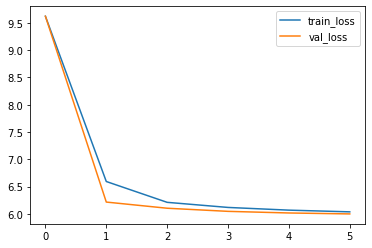

In [12]:
df = pd.DataFrame(metrics).T
plt.figure()
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Testing

In [13]:
sent = 'Historians write in the context of their own time and with due regard to the current dominant ideas of how to interpret the past'
ind = [train_dataset.get_idx(w.lower()) for w in sent.split(' ')]
print(ind)
hidden = model.init_hidden(1)
inputs = torch.tensor([ind]).to(DEVICE)
model.eval()
output, _ = model(inputs, hidden)
preds = output.view(-1, model.vocab_size)

[2595, 1389, 5, 2, 3086, 3, 29, 252, 51, 4, 14, 175, 3223, 6, 2, 1014, 3684, 1794, 3, 373, 6, 0, 2, 757]


In [14]:
for top4 in preds.topk(3).indices:
    res = []
    for l in top4:
        w = vocabulary.idx_to_word[l.item()]
        res.append(w)
    print(res)

['of', 'are', 'and']
['that', 'the', 'a']
['the', 'a', 'this']
['world', 'game', 'same']
['of', 'and', 'as']
['the', 'a', 'his']
['own', 'life', 'and']
['and', 'life', 'as']
['and', 'in', 'the']
['the', 'a', 'other']
['the', 'a', 'their']
['to', 'for', 'from']
['to', 'the', 'by']
['the', 'a', 'their']
['church', 'world', 'city']
['and', 'century', 'level']
['and', 'in', 'of']
['of', 'and', 'for']
['the', 'a', 'their']
['the', 'it', 'to']
['the', 'be', 'have']
['the', 'and', 'their']
['song', 'same', 'world']
['the', 'and', 'a']


In [15]:
model.freeze_embeddings()

In [16]:
metrics = model.fit(
    train_dataloader = train_dataloader,
    eval_dataloader = val_dataloader,
    num_epochs = 5,
    early_stopping = True,
    early_stopping_patience = 2,
    early_stopping_metric = 'val_loss',
    early_stopping_metric_best = 'min', # if lower is better (like for loss)
)

  0%|          | 8/6870 [00:00<01:34, 72.81it/s]

Train loss at epoch 0 : 5.869343998824318
Eval loss at epoch 0 : 5.951654611996242
updating best metric


  8%|▊         | 541/6870 [00:06<01:11, 88.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 47%|████▋     | 3197/6870 [00:36<00:41, 88.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 79%|███████▉  | 5412/6870 [01:01<00:16, 88.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  0%|          | 8/6870 [00:00<01:32, 74.43it/s]

Train loss at epoch 1 : 5.948602914740772
Eval loss at epoch 1 : 5.944996579715184
updating best metric


 16%|█▌        | 1078/6870 [00:12<01:05, 88.67it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 72%|███████▏  | 4924/6870 [00:56<00:21, 88.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


  0%|          | 8/6870 [00:00<01:25, 79.99it/s]

Train loss at epoch 2 : 5.937287572169408
Eval loss at epoch 2 : 5.935415239334106
updating best metric


  2%|▏         | 125/6870 [00:01<01:18, 85.67it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 36%|███▋      | 2492/6870 [00:28<00:49, 88.37it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 95%|█████████▍| 6505/6870 [01:14<00:04, 89.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 9/6870 [00:00<01:23, 82.10it/s]

Train loss at epoch 3 : 5.929110312635374
Eval loss at epoch 3 : 5.931431913375855
updating best metric


 24%|██▍       | 1636/6870 [00:18<00:58, 88.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 37%|███▋      | 2568/6870 [00:29<00:48, 88.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 55%|█████▌    | 3785/6870 [00:42<00:34, 88.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  0%|          | 8/6870 [00:00<01:27, 78.51it/s]

Train loss at epoch 4 : 5.923672549207485
Eval loss at epoch 4 : 5.9318472712380546


 14%|█▍        | 953/6870 [00:10<01:06, 88.55it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 53%|█████▎    | 3647/6870 [00:41<00:36, 88.61it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


 83%|████████▎ | 5727/6870 [01:05<00:12, 88.40it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0


100%|██████████| 700/700 [00:02<00:00, 235.83it/s]

Train loss at epoch 5 : 5.9180255427631225
Eval loss at epoch 5 : 5.920863290514265
updating best metric
